In [1]:
import numpy as np
import pandas as pd
import gget
import glob
import networkx as nx
import os
import seaborn as sns
import gget
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import zscore
import scipy

# Load sc data

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/analysis.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]
adata

AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

# Load isoforms

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/isoforms/isoform_data.parquet"

df = pd.read_parquet(fpath)
df = df[df['cell_id'].isin(adata.obs_names)] # filter out undetected CBs
print(f"{df.shape=}")
df.head()

df.shape=(11373142, 8)


,isoform_id,gene_id,run_id,cell_id,UMI,read_name,gene_name,transcript_name
0,ENST00000483767,ENSG00000188976,Run3x0418,TGTGGCGGTAACGGTG,AAGTTTACCGGG,b43c7b93-2130-42e0-a51d-2819bedeb593,NOC2L,NOC2L-204
1,ENST00000483767,ENSG00000188976,Run3x0418,CTAACTTGTCGTCATA,TTTTGGATCTTT,5887c2fa-b3bd-4a22-b3f8-4ce31b4e9d0d,NOC2L,NOC2L-204
2,ENST00000483767,ENSG00000188976,Run3x0418,AAGATAGAGTTGGGAC,AACGGGTCCTCT,050743c4-d895-45d6-b59a-c5232b6ac1b1,NOC2L,NOC2L-204
3,ENST00000469563,ENSG00000188976,Run3x0418,TATACCTAGTCGGCCT,AACGGTTAGCCG,f24c150f-2a5a-4581-96a7-081d004d28c6,NOC2L,NOC2L-202
4,ENST00000469563,ENSG00000188976,Run3x0418,TGTAAGCGTGTCATTG,AAACTCTAACTT,166e19dc-cd7c-4ee2-b35e-eb3ceb455285,NOC2L,NOC2L-202


# Plot some

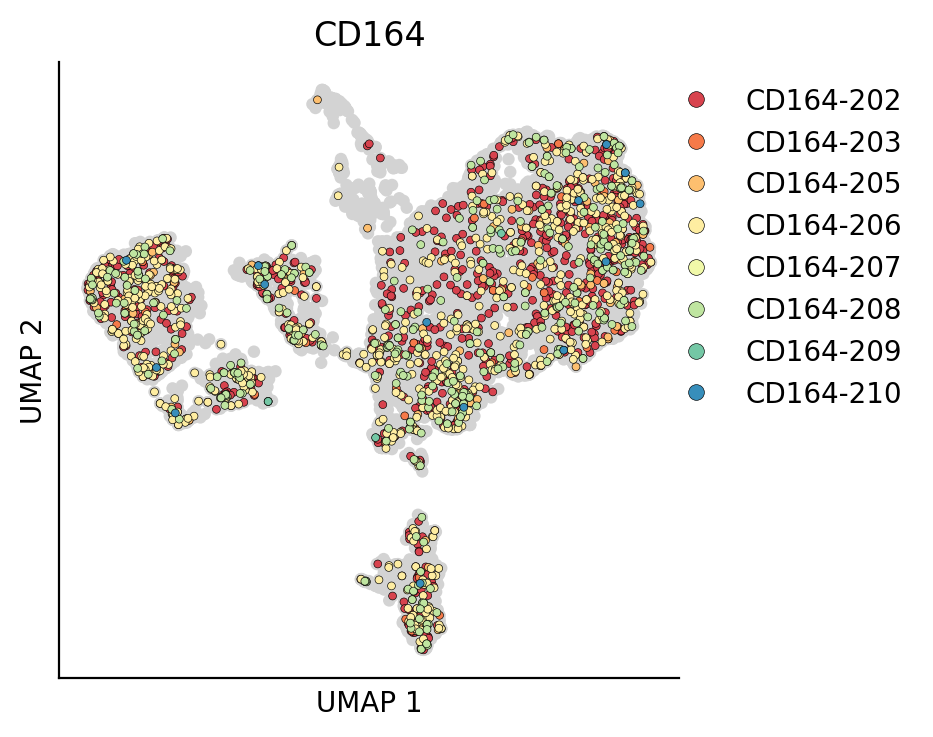

In [4]:
def plot_isoform_umap(adata, df, query, size=15, palette='Spectral'):
    """
    Plots UMAP visualization of gene expression for a given query gene, with customizable parameters.

    Args:
        adata: AnnData object containing the expression data and UMAP coordinates.
        df: DataFrame containing gene annotations (gene_name, transcript_name, etc.).
        query: String representing the query gene name.
        size: Integer controlling the size of the scatterplot markers.
        palette: String or list specifying the color palette for the transcript_name hue.
    """

    pdf = adata.obs.copy()
    pdf = pdf.reset_index()

    query_df = df[df['gene_name'] == query]
    
    if query_df.empty:
        return

    pdf = pd.merge(pdf, query_df, how='left')
    pdf = pdf.sort_values(by='transcript_name')

    sns.scatterplot(
        data=pdf,
        x='UMAP 1',
        y='UMAP 2',
        color='lightgrey',
        zorder=0,
        ec='none',
        s=size,
    )

    sns.scatterplot(
        data=pdf,
        x='UMAP 1',
        y='UMAP 2',
        hue='transcript_name',
        ec='k',
        s=size / 2.5,
        palette=palette,
    )

    plt.xticks([])
    plt.yticks([])

    plt.ylabel('UMAP 2')
    plt.xlabel('UMAP 1')

    sns.despine()

    plt.title(query)
    plt.gca().set_aspect('auto')

    sns.move_legend(
        plt.gca(),
        loc='upper right',
        title="",
        frameon=False,
        bbox_to_anchor=(1.4, 1),
        markerscale=2,
    )
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
plot_isoform_umap(adata, df, query='CD164', size=20)

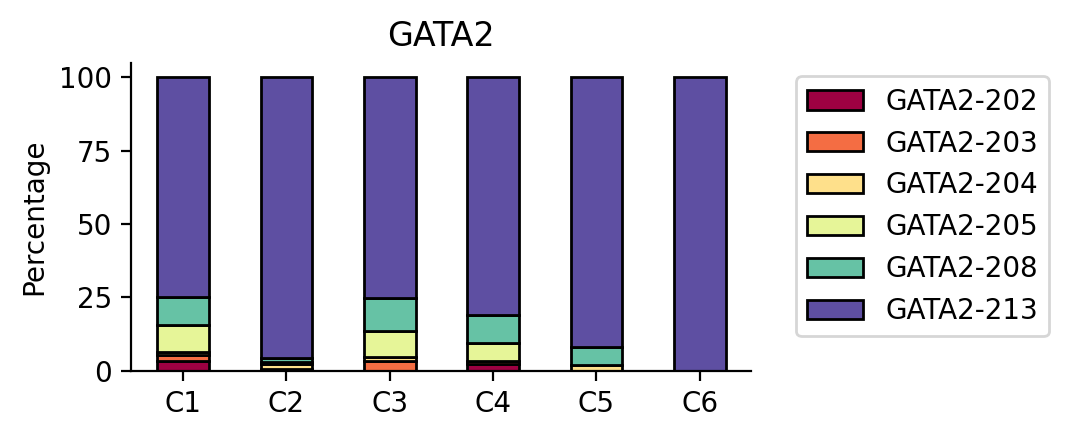

In [5]:
def plot_cluster_expression(adata, df, query, palette='Spectral'):
    """
    Plots stacked bar charts showing the percentage of each cluster expressing each transcript for a given query gene.

    Args:
        adata: AnnData object containing the expression data and UMAP coordinates.
        df: DataFrame containing gene annotations (gene_name, transcript_name, etc.).
        query: String representing the query gene name.
        palette: String or list specifying the color palette for the transcript_name hue.
    """

    pdf = adata.obs.copy()
    pdf = pdf.reset_index()

    query_df = df[df['gene_name'] == query]

    if query_df.empty:
        return

    pdf = pd.merge(pdf, query_df, how='left')
    pdf = pdf.sort_values(by='transcript_name')

    # Group by cluster and transcript, count the number of cells expressing each transcript
    expression_counts = pdf.groupby(['cluster_str', 'transcript_name'], 
                                    observed=True).size().unstack(fill_value=0)

    # Calculate the percentage of cells expressing each transcript within each cluster
    percentage_expression = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 100

    # Plot stacked bar charts
    percentage_expression.plot(
        kind='bar',
        stacked=True,
        colormap=palette,
        ec="k",
    )
    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.title(f'{query}')
    plt.gca().tick_params(axis='x', rotation=0)
    sns.despine()
    plt.legend(
        title='', 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left')
    
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plot_cluster_expression(adata, df, query='GATA2', palette='Spectral')  

n genes: 8


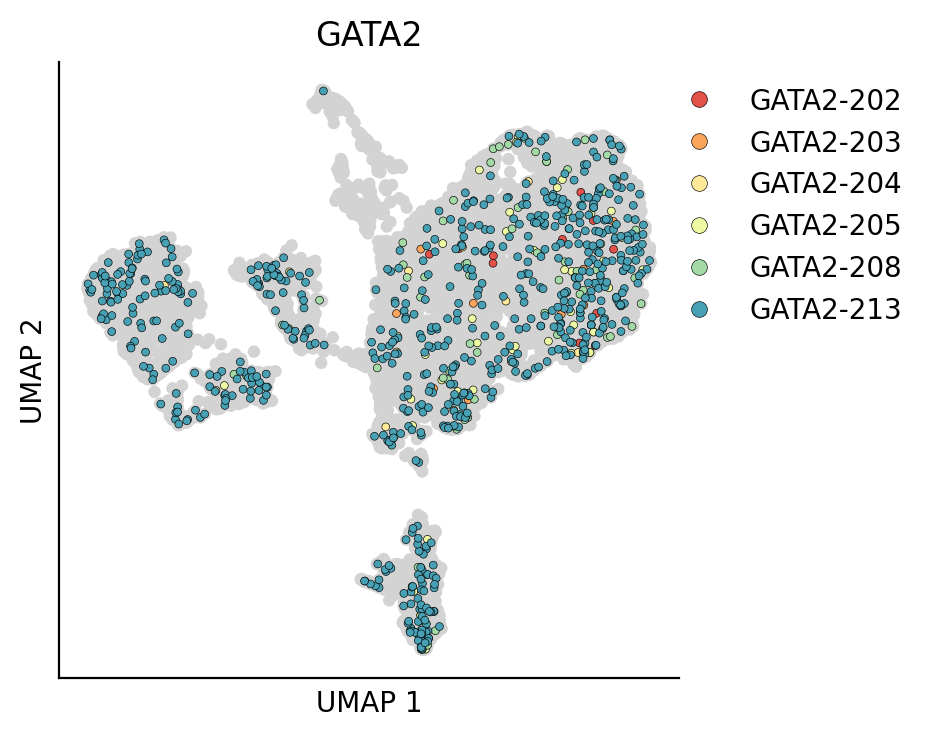

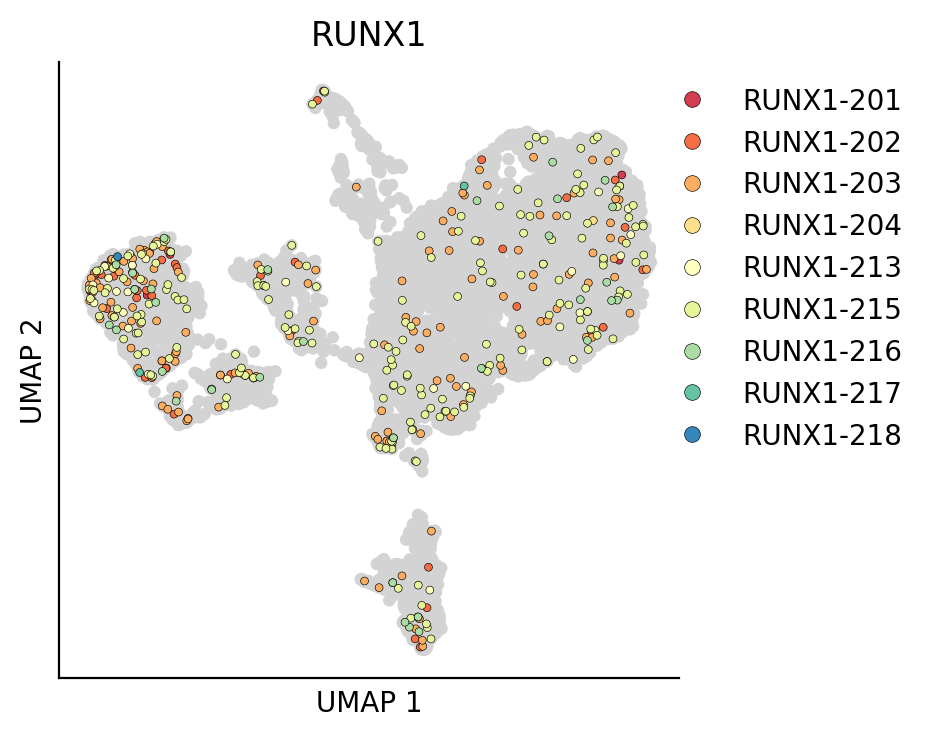

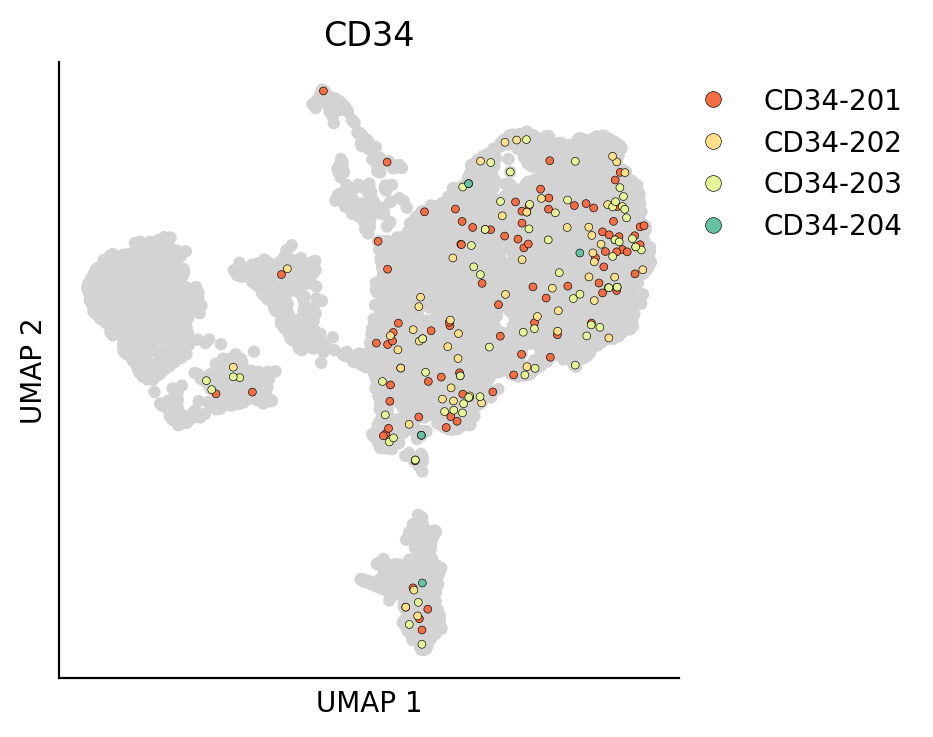

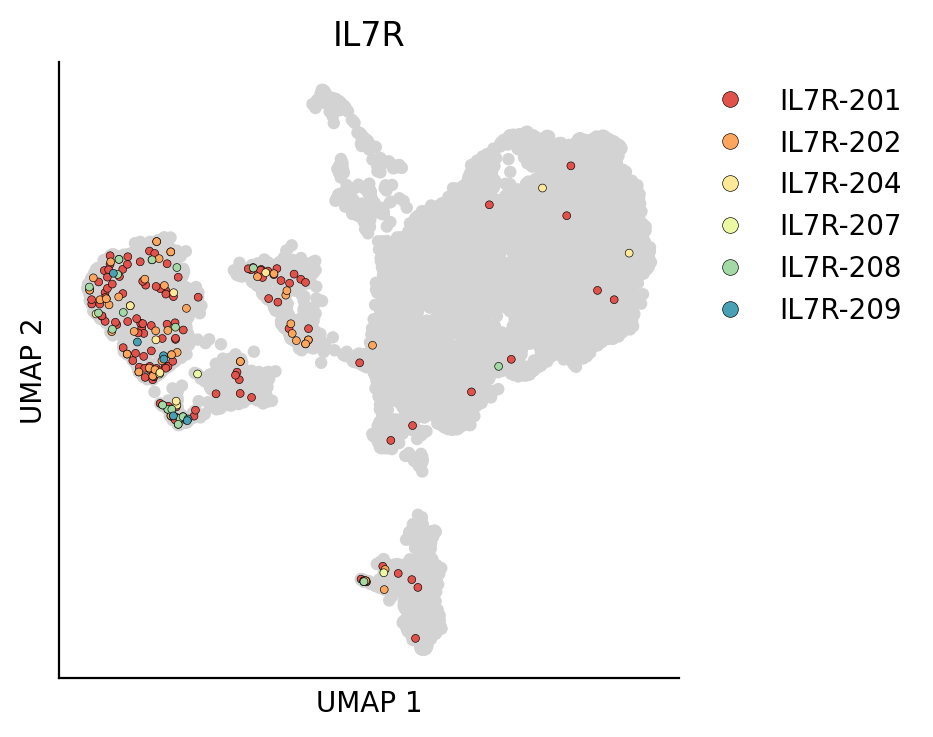

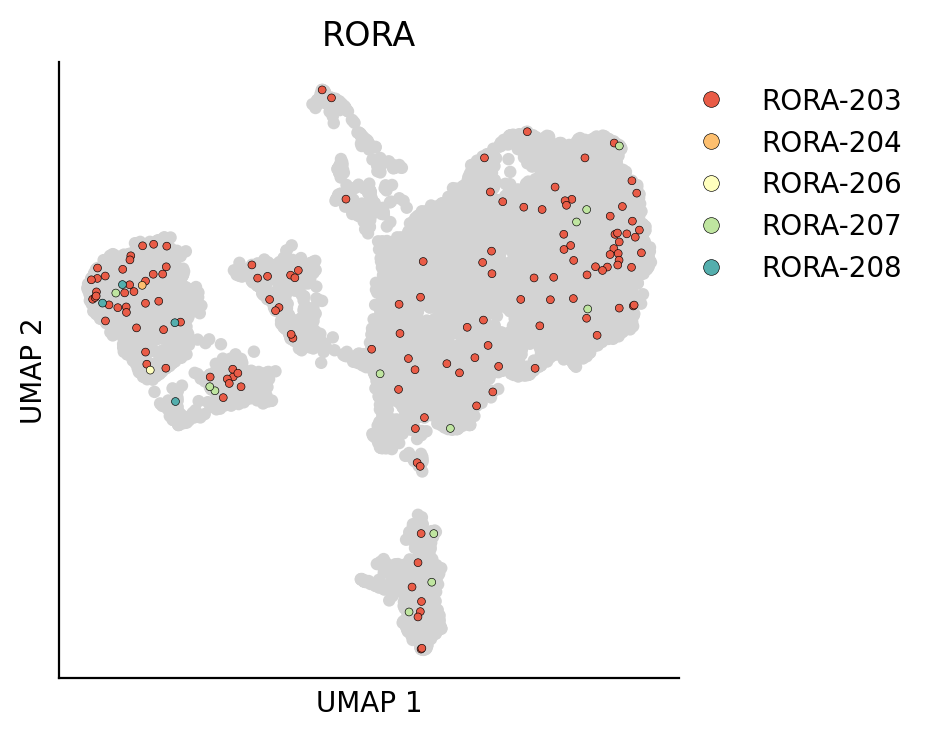

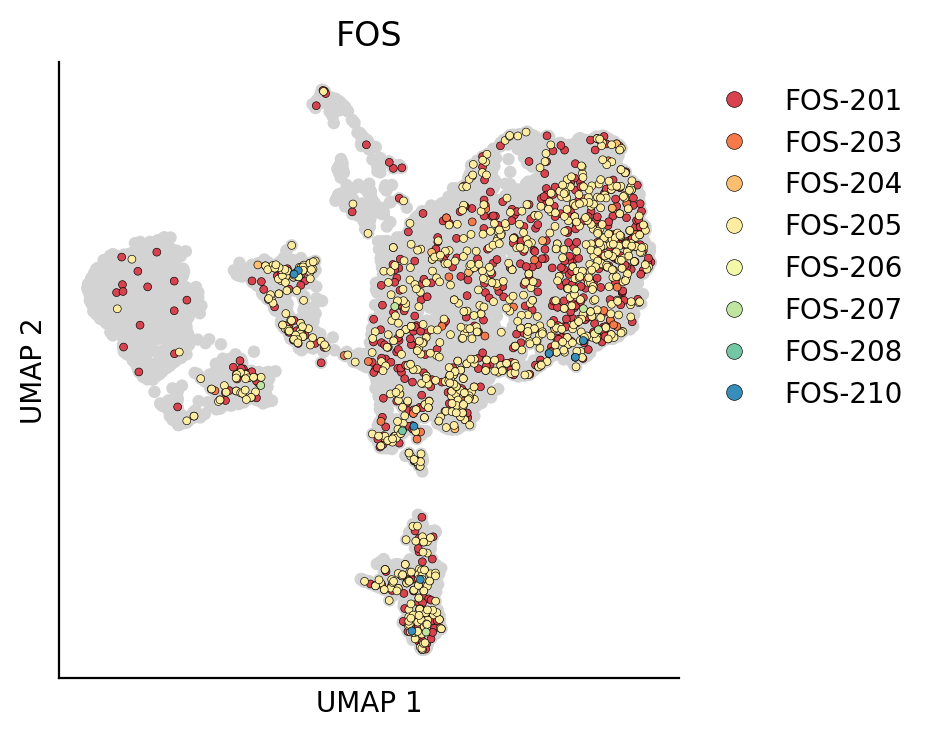

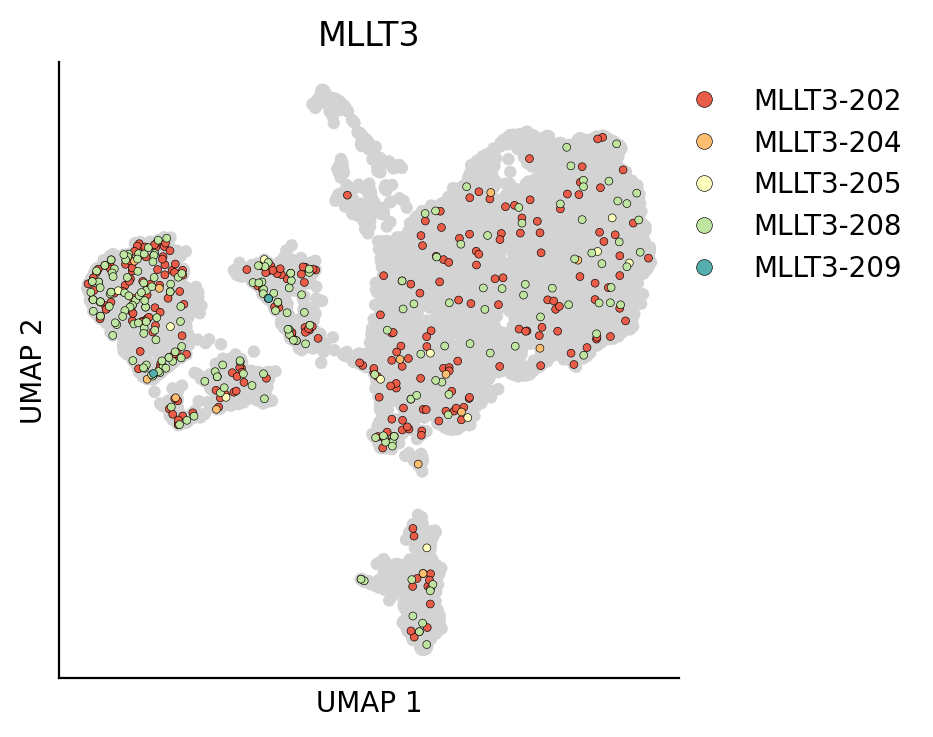

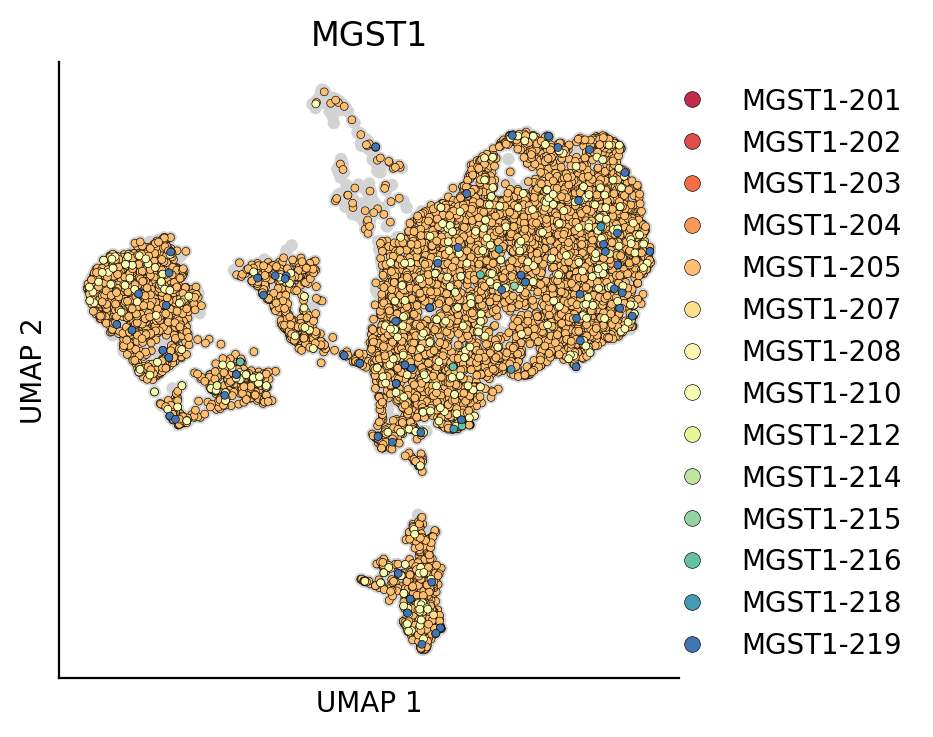

In [6]:
gene_list = [
    'GATA2', 'RUNX1', 'CD34', 'IL7R', 'RORA', 'FOS','MLLT3','MGST1',
]

gene_list = [x for x in gene_list if x in adata.var['gene_name'].values]
print(f"n genes: {len(gene_list)}")

for gene in gene_list:
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 4, 4
    plot_isoform_umap(
        adata, 
        df, 
        query=gene, 
        size=20,
    )
    plt.show()

# Differential ISO Explore

In [7]:
df['value'] = 1
df.head()

,isoform_id,gene_id,run_id,cell_id,UMI,read_name,gene_name,transcript_name,value
0,ENST00000483767,ENSG00000188976,Run3x0418,TGTGGCGGTAACGGTG,AAGTTTACCGGG,b43c7b93-2130-42e0-a51d-2819bedeb593,NOC2L,NOC2L-204,1
1,ENST00000483767,ENSG00000188976,Run3x0418,CTAACTTGTCGTCATA,TTTTGGATCTTT,5887c2fa-b3bd-4a22-b3f8-4ce31b4e9d0d,NOC2L,NOC2L-204,1
2,ENST00000483767,ENSG00000188976,Run3x0418,AAGATAGAGTTGGGAC,AACGGGTCCTCT,050743c4-d895-45d6-b59a-c5232b6ac1b1,NOC2L,NOC2L-204,1
3,ENST00000469563,ENSG00000188976,Run3x0418,TATACCTAGTCGGCCT,AACGGTTAGCCG,f24c150f-2a5a-4581-96a7-081d004d28c6,NOC2L,NOC2L-202,1
4,ENST00000469563,ENSG00000188976,Run3x0418,TGTAAGCGTGTCATTG,AAACTCTAACTT,166e19dc-cd7c-4ee2-b35e-eb3ceb455285,NOC2L,NOC2L-202,1


In [8]:
# create a cell x transcript matrix
X = pd.pivot_table(
    df, 
    index='cell_id',
    columns='transcript_name',
    values='value',
    fill_value=0.0,
)

print(f"{X.shape=}")

# map clusters
group_map = dict(zip(adata.obs.index, adata.obs.cluster_str))

X['cluster'] = X.index.map(group_map)
X.head()

X.shape=(8563, 75541)


transcript_name,A1BG-201,A1BG-202,A1BG-203,A1BG-204,A2M-201,A2M-205,A2M-207,A4GALT-201,A4GALT-202,A4GALT-205,...,ZZEF1-210,ZZZ3-201,ZZZ3-202,ZZZ3-204,ZZZ3-205,ZZZ3-206,ZZZ3-209,ZZZ3-210,ZZZ3-211,cluster
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGGTTACCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C1
AAACCCAAGTTGAAGT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C1
AAACCCAAGTTGTCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C4
AAACCCACAGAAGCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C2
AAACCCACAGGAGGTT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C1


In [ ]:
# compute proportions and pivot 
prop = X.groupby('cluster').mean().T

# DROP C6
prop = prop.drop(columns=['C6'])

prop['std'] = prop.std(axis=1)
prop = prop.sort_values(by='std', ascending=False)

prop.head(25)

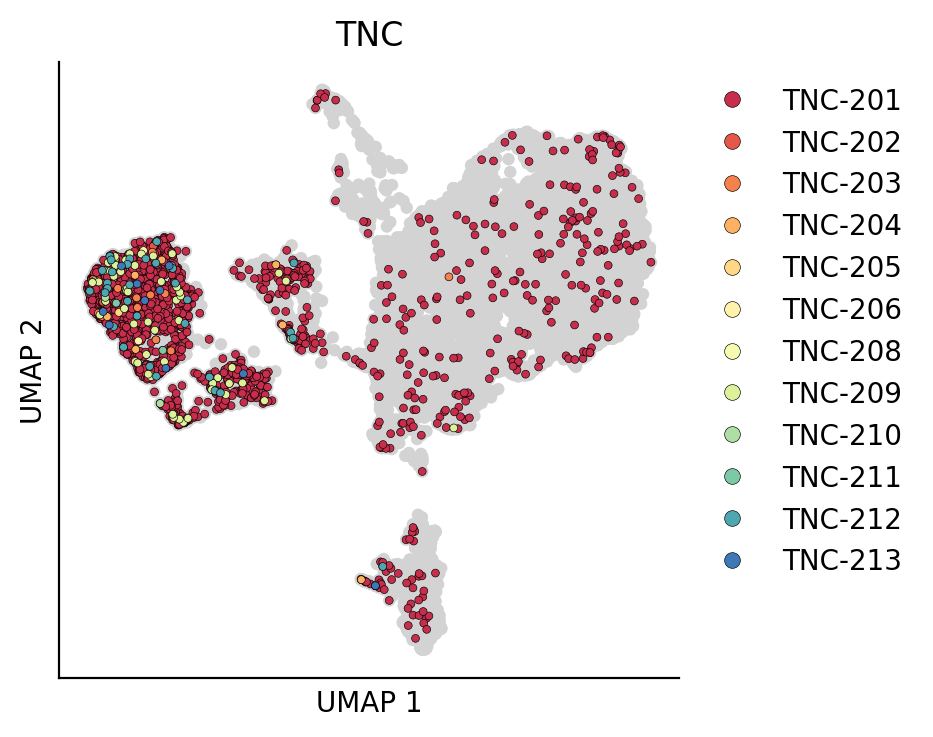

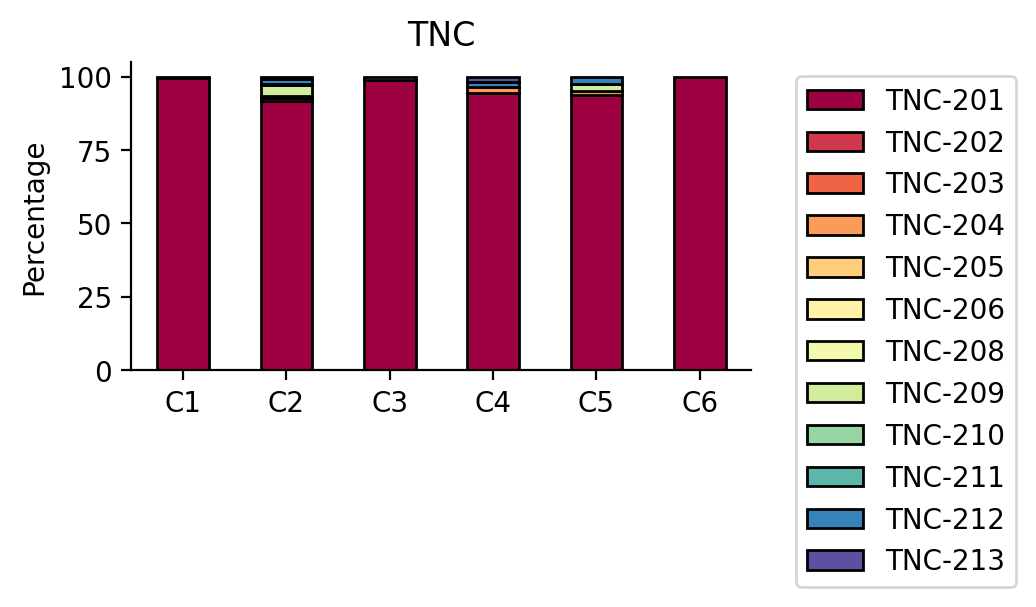

In [48]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

query = 'TNC'

plot_isoform_umap(adata, df, query=query, size=20)
plt.show()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plot_cluster_expression(adata, df, query)
plt.show()

# STDEV enrichments

In [16]:
n_genes = 100
database = 'ontology'
query_genes = list(prop.head(n_genes).index)
query_genes = [x.split("-")[0] for x in query_genes]

edf = gget.enrichr(
    query_genes, 
    database=database,
)

pd.set_option('display.max_colwidth', 150)
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(10)

Thu Aug 15 11:30:30 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,adj_p_val,overlapping_genes
0,extracellular structure organization (GO:0043062),0.000001,"[FBN2, LOX, COL4A2, LUM, COL4A1, MMP3, SERPINE1, TNC, LAMC1, THBS1, DCN]"
1,external encapsulating structure organization (GO:0045229),0.000001,"[FBN2, LOX, COL4A2, LUM, COL4A1, MMP3, SERPINE1, TNC, LAMC1, THBS1, DCN]"
2,extracellular matrix organization (GO:0030198),0.000002,"[GREM1, FBN2, LOX, COL4A2, LUM, COL4A1, MMP3, SERPINE1, TNC, LAMC1, THBS1, DCN]"
3,mitotic spindle organization (GO:0007052),0.000104,"[CENPF, PRC1, PLK1, STMN1, CENPN, DLGAP5, MAD2L1, SPC25]"
4,regulation of cell cycle (GO:0051726),0.000126,"[CCNB2, CENPF, DUSP1, PLK1, PCLAF, CKS2, THBS1, DLGAP5, CDKN3, CKS1B]"
5,microtubule cytoskeleton organization involved in mitosis (GO:1902850),0.000236,"[CENPF, PLK1, STMN1, CENPN, DLGAP5, MAD2L1, SPC25]"
6,regulation of mitotic metaphase/anaphase transition (GO:0030071),0.000660,"[DUSP1, UBE2C, PLK1, DLGAP5]"
7,kinetochore assembly (GO:0051382),0.000816,"[CENPF, CENPW, DLGAP5]"
8,centromere complex assembly (GO:0034508),0.002188,"[CENPF, CENPW, CENPN, DLGAP5]"
9,kinetochore organization (GO:0051383),0.002194,"[CENPF, CENPW, DLGAP5]"


# Rank-value encoding

In [37]:
ranks = prop.copy()
ranks = ranks.drop(columns=['std'])
ranks = ranks.rank(axis=1, ascending=False, pct=True)

sort_by = 'C2'

ranks = ranks[ranks[sort_by] == 1]

print(f"{ranks.shape=}")


ranks.head(15)

ranks.shape=(11758, 5)


cluster,C1,C2,C3,C4,C5
transcript_name,,,,,
MGP-203,0.2,1.0,0.6,0.4,0.8
CLU-215,0.2,1.0,0.4,0.6,0.8
H4C3-201,0.6,1.0,0.8,0.2,0.4
KRT18-201,0.2,1.0,0.6,0.4,0.8
MGP-204,0.2,1.0,0.6,0.4,0.8
ARL6IP1-201,0.6,1.0,0.4,0.2,0.8
BLVRB-201,0.4,1.0,0.6,0.2,0.8
LXN-201,0.2,1.0,0.4,0.6,0.8
CLIC3-203,0.4,1.0,0.2,0.6,0.8


In [36]:
n_genes = 100
database = 'ontology'
query_genes = list(ranks.head(n_genes).index)
query_genes = [x.split("-")[0] for x in query_genes]

edf = gget.enrichr(
    query_genes, 
    database=database,
)

pd.set_option('display.max_colwidth', 150)
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(10)

Thu Aug 15 11:39:39 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,adj_p_val,overlapping_genes
0,spliceosomal snRNP assembly (GO:0000387),0.021447,"[SNRPD1, SNRPG, LSM2, SNRPB]"
1,negative regulation of growth (GO:0045926),0.075443,"[CDA, BTG1, MT1X, ENO1, MT1E]"
2,mRNA processing (GO:0006397),0.075443,"[LSM7, SNRPD1, SNRPG, PABPC1, AURKAIP1, SNRPB, LSM2]"
3,import into nucleus (GO:0051170),0.075443,"[SNRPD1, SNRPG, RAN, SNRPB]"
4,tRNA threonylcarbamoyladenosine metabolic process (GO:0070525),0.075443,"[TPRKB, LAGE3]"
5,positive regulation of leukocyte differentiation (GO:1902107),0.077496,"[PRKDC, HMGB1]"
6,positive regulation of binding (GO:0051099),0.077496,"[CAV1, HMGB1, RAN, HIPK2]"
7,nucleocytoplasmic transport (GO:0006913),0.077496,"[SNRPD1, SNRPG, SNRPB]"
8,mRNA metabolic process (GO:0016071),0.077496,"[SNRPG, AURKAIP1, SNRPB, LSM2]"
9,"RNA splicing, via transesterification reactions with bulged adenosine as nucleophile (GO:0000377)",0.077496,"[LSM7, SNRPD1, SNRPG, PABPC1, SNRPB, LSM2]"


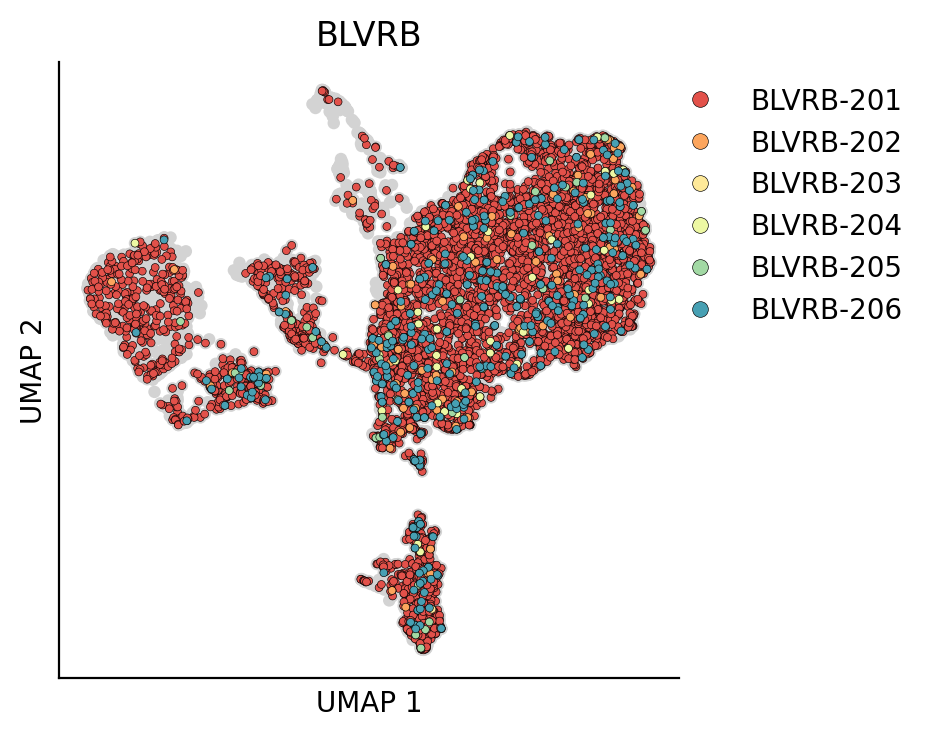

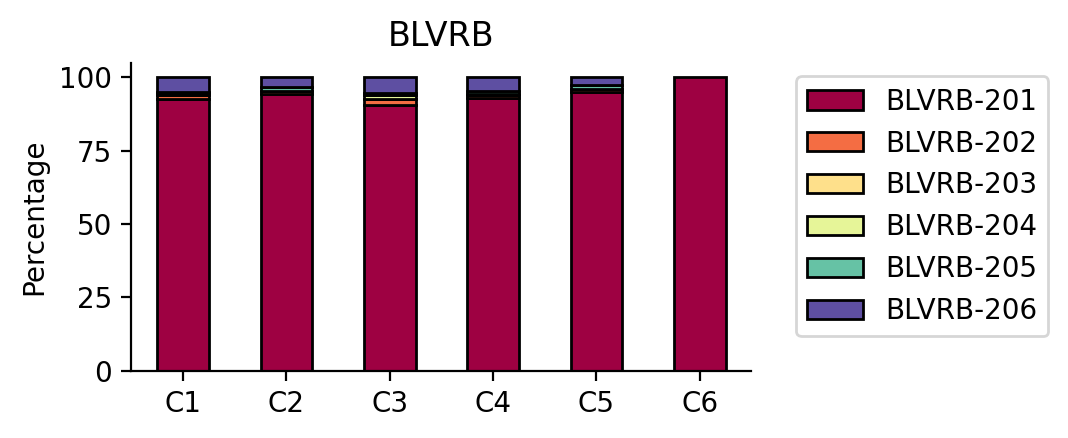

In [38]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

query = 'BLVRB'

plot_isoform_umap(adata, df, query=query, size=20)
plt.show()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plot_cluster_expression(adata, df, query)
plt.show()

In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Z scoring

In [ ]:
zdf = proportions.copy()
zdf = zdf.drop(columns=['std'])

# remove boring transcripts
row_sums = zdf.sum(axis=1)
mask = (row_sums != 0) & (row_sums != 1)
zdf = zdf[mask]

# z scoring
zdf = zscore(zdf, axis=1)

sort_by = 'C2'
zdf = zdf.sort_values(by=sort_by, ascending=False)

zdf = zdf[zdf[sort_by] < 1.999999]

zdf.head(15)

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

query = 'LAMA4'

plot_isoform_umap(adata, df, query=query, size=20)
plt.show()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plot_cluster_expression(adata, df, query)
plt.show()

# Enrichments

In [ ]:
sort_by = 'C4'
# database = 'ontology'
# database = 'PanglaoDB_Augmented_2021'
database = 'Tabula_Sapiens'
database = 'TRRUST_Transcription_Factors_2019'
n_genes = 55
zdf = zdf.sort_values(by=sort_by, ascending=False)

query_genes = list(zdf.head(n_genes).index)
query_genes = [x.split("-")[0] for x in query_genes]

edf = gget.enrichr(
    query_genes, 
    database=database,
)

pd.set_option('display.max_colwidth', 150)
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(10)

# zdf.head(20)

In [ ]:
break

In [ ]:
# def find_significant_transcripts(df, alpha=0.05):
#     """
#     Identifies transcript names whose values significantly differ by cluster using ANOVA.

#     Args:
#         df: DataFrame with columns 'transcript_name', 'cluster', and 'value'.
#         alpha: Significance level for the ANOVA test (default: 0.05).

#     Returns:
#         DataFrame: Table of results including transcript_name, F-statistic, and p-value.
#     """

#     def perform_anova(group):
#         """Performs ANOVA on a group of values."""
#         groups = [group[group['cluster'] == cluster]['value'] for cluster in df['cluster'].unique()]
#         # Check if there are enough groups for ANOVA (at least 2)
#         if len(groups) < 2:
#             return pd.Series({'F-statistic': np.nan, 'p-value': np.nan})
#         # Handle the case where a group might be empty
#         groups = [g for g in groups if not g.empty]
#         f_statistic, p_value = f_oneway(*groups)
#         return pd.Series({'F-statistic': f_statistic, 'p-value': p_value})

#     # Group by transcript_name and apply ANOVA
#     results_df = df.groupby('transcript_name').apply(perform_anova)

#     # Filter for statistically significant differences based on alpha
#     significant_transcripts = results_df[results_df['p-value'] < alpha]

#     return significant_transcripts


# test = proportions.copy().reset_index()
# test = test.drop(columns=['std'])
# test = pd.melt(
#     test,
#     id_vars='transcript_name'
# )

# res = find_significant_transcripts(test)
# res.head()

In [ ]:
break

In [ ]:
gene_list = [
    'LMBR1L', 'CHD2', 'UFL1', 'SRF', 'ACE', 'XRCC5', 'TAL1', 'ERCC2',
    'ZFP36', 'MLLT3', 'CDK6', 'MED1', 'SFRP1', 'SH2B3', 'GBA',
    'YJEFN3', 'SNAI2', 'ARIH2', 'WNT1', 'CD34', 'ETV6', 'WNT5A',
    'CEBPA', 'BRCA2', 'RUNX1', 'MECOM', 'SART3', 'SHB', 'NKAP',
    'WNT2B', 'SFRP2', 'BABAM1', 'YTHDF2', 'SEPTIN4', 'GATA2', 'CCN3',
    'ADAR', 'SOX4', 'ARHGEF5', 'FSTL1', 'UBAP2L', 'EMCN', 'OCIAD2',
    'NBEA', 'MYCT1', 'BAP1', 'GPRASP2', 'GLIS2', 'CRISPLD1', 'NLE1',
    'OCIAD1', 'ADGRG1',
]

for gene in gene_list:
    plot_isoform_umap(
        adata, 
        df, 
        query=gene, 
        size=20,
    )
    plt.show()
    


In [ ]:
query = 'CD59'

pdf = adata.obs.copy()
pdf = pdf.reset_index()

query_df = df[df['gene_name'] == query]

pdf = pd.merge(
    pdf, 
    query_df,
    how='left',
)

pdf = pdf.sort_values(by='transcript_name')


size = 15
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=pdf, 
    x='UMAP 1',
    y='UMAP 2',
    color='lightgrey',
    zorder=0,
    ec='none',
    s=size,
)

sns.scatterplot(
    data=pdf, 
    x='UMAP 1',
    y='UMAP 2',
    hue='transcript_name',
    ec='k',
    s= size / 2.5,
    # palette='viridis',
    palette='Spectral',
)

plt.xticks([])
plt.yticks([])

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')

sns.despine()

plt.title(query)
plt.gca().set_aspect('auto')

sns.move_legend(
    plt.gca(),
    loc='upper right',
    title="",
    frameon=False,
    bbox_to_anchor=(1.6, 1),
    markerscale=2,
)

In [ ]:
break

In [ ]:
adata.obs.head()

# filter out the genes we care about

In [ ]:
gene_list = [
    'GATA2',
    'KIT',
    'MPL',
    'LMO2'
]

pdf = df[df['gene_name'].isin(gene_list)]
print(f"{pdf.shape=}")
pdf.head()

In [ ]:
break